Plot the Stein witness function, and the mean/std objective as a function of the test locations.

In [1]:
%load_ext autoreload
%autoreload 2
%matplotlib inline
#%config InlineBackend.figure_format = 'svg'
#%config InlineBackend.figure_format = 'pdf'

import kgof
import kgof.data as data
import kgof.density as density
import kgof.goftest as gof
import kgof.kernel as kernel
import kgof.util as util
import matplotlib
import matplotlib.pyplot as plt
import autograd.numpy as np
import scipy.stats as stats

In [2]:
# font options
font = {
    #'family' : 'normal',
    #'weight' : 'bold',
    'size'   : 18
}

plt.rc('font', **font)
plt.rc('lines', linewidth=2)
matplotlib.rcParams['pdf.fonttype'] = 42
matplotlib.rcParams['ps.fonttype'] = 42

## Surface plots in 2d

In [3]:
def generic_contourf(p, dat, k, func):
    """
    func: (p, dat, k, V) |-> value. A function computing the values to plot.
    """
    # should be an n x 2 matrix. 2d data.
    X = dat.data()
    max0, max1 = np.max(X, 0)
    min0, min1 = np.min(X, 0)
    
    #sd1, sd2 = np.std(XY, 0)
    sd0, sd1 = ((max0-min0)*0.4, (max1-min1)*0.4)
    # form a test location grid to try 
    nd0 = 50
    nd1 = 50
    loc0_cands = np.linspace(min0-sd0/2, max0+sd0/2, nd0)
    loc1_cands = np.linspace(min1-sd1/2, max1+sd1/2, nd1)
    lloc0, lloc1 = np.meshgrid(loc0_cands, loc1_cands)
    # nd1 x nd0 x 2
    loc3d = np.dstack((lloc0, lloc1))
    # #candidates x 2
    all_loc2s = np.reshape(loc3d, (-1, 2) )

    # all_locs = #candidates x J x 2
    #all_locs = np.array( [np.vstack((c, loc1)) for c in all_loc2s] )
    
    # evaluate the function on each candidate T on the grid. Size = (#candidates, )
    stat_grid = np.array([func(p, dat, k, np.array([T])) for T in all_loc2s])
    stat_grid = np.reshape(stat_grid, (nd1, nd0) )

    den_grid = np.exp(p.log_normalized_den(all_loc2s))
    den_grid = np.reshape(den_grid, (nd1, nd0))
    #ax = fig.gca(projection='3d')
    #ax.plot_surface(lloc1, lloc2, stat_grid, rstride=8, cstride=8, alpha=0.3)
    #cset = ax.contourf(lloc1, lloc2, stat_grid, zdir='z', offset=0, cmap=cm.coolwarm)
    plt.figure(figsize=(10, 6))
    # Plot the unnormalized density
    CS = plt.contour(
        lloc0, lloc1, den_grid, alpha=0.6, 
        #colors=('#500000', '#900000', '#d00000'),
        #colors=plt.cm.Blues(3),
    )
    #plt.clabel(CS, fontsize=12, inline=1, fmt='%1.1f', colors='k')
    plt.contourf(lloc0, lloc1, stat_grid, cmap=plt.cm.Greys, alpha=0.7)
    
    #plt.gca().get_xaxis().set_visible(False)
    #plt.gca().get_yaxis().set_visible(False)
    #plt.axis('off')
    #plt.colorbar()

    max_stat = np.max(stat_grid)
    #plt.xlabel('')
    #plt.ylabel('')
    n = X.shape[0]
    #ax.view_init(elev=max_stat*2, azim=90)

    # plot the data
    plt.plot(X[:, 0], X[:, 1], '.m', markeredgecolor='m', markersize=4, alpha=0.8)
    #plt.xlabel('$X$')
    #plt.ylabelel('$Y$')
    
    # return the locations V
    
    max_ind = np.argmax(stat_grid.reshape(-1))
    V = all_loc2s[max_ind]
    print 'V: %s'%V
    
    # put a star at the highest location
    plt.plot(V[0], V[1], 'r*', markersize=25)
    return V
 

In [4]:
def func_fssd(p, dat, k, V):
    """
    Return the value of FSSD test statistic.
    """
    fssd = gof.FSSD(p, k, V, alpha=0.01, null_sim=None)
    return fssd.compute_stat(dat)

def func_fssd_power_criterion(p, dat, k, V):
    """
    Return the value of the power criterion of FSSD.
    """
    return gof.FSSD.power_criterion(p, dat, k, V)
    
def func_fssd_ustat_std(p, dat, k, V):
    """
    Return the standard deviation of the U-statistic
    """
    fssd = gof.FSSD(p, k, V, alpha=0.01, null_sim=None)
    X = dat.data()
    fea_tensor = fssd.feature_tensor(X)
    _, variance = gof.FSSD.ustat_h1_mean_variance(fea_tensor, return_variance=True)
    return np.sqrt(variance)

In [5]:
# true p
seed = 15
d = 2
mean = np.zeros(d)
variance = 1
isonorm = density.IsotropicNormal(mean, variance)

In [6]:
# sample
n = 600

# only one dimension of the mean is shifted
#draw_mean = mean + np.hstack((1, np.zeros(d-1)))
draw_mean = mean + 1
draw_variance = variance + 0
X = util.randn(n, d, seed=seed+3)*np.sqrt(draw_variance) + draw_mean
dat = data.Data(X)

# Scaling of 1/sqrt(2) will make the variance 1.
# ds_laplace = data.DSLaplace(d=d, loc=0, scale=1.0/np.sqrt(2))
# dat = ds_laplace.sample(n, seed=4)

In [7]:
# Kernel
sig2 = util.meddistance(X, subsample=1000)**2
k = kernel.KGauss(sig2)

# Test
J = 1
alpha = 0.01

# random test locations
V = util.fit_gaussian_draw(X, J, seed=seed+1)
null_sim = gof.FSSDH0SimCovObs(n_simulate=1000, seed=10)
fssd = gof.FSSD(isonorm, k, V, null_sim=null_sim, alpha=alpha)

fssd.perform_test(dat)

{'alpha': 0.01,
 'h0_rejected': True,
 'n_simulate': 1000,
 'pvalue': 0.0,
 'test_stat': 180.74612042209284,
 'time_secs': 0.008128881454467773}

In [8]:
p = isonorm

V: [ 1.00350866  1.01715941]


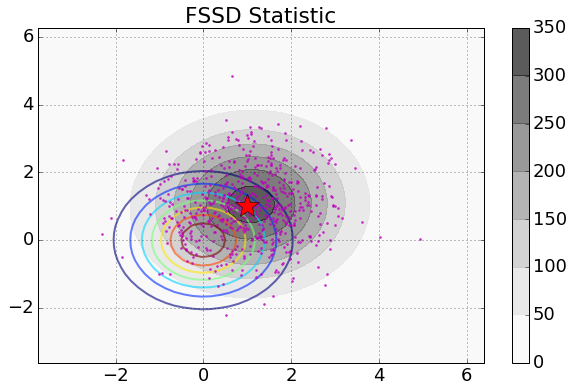

In [9]:
generic_contourf(p, dat, k, func_fssd)
plt.title('FSSD Statistic')
plt.colorbar()
plt.grid()

V: [-0.03438204 -0.19236854]


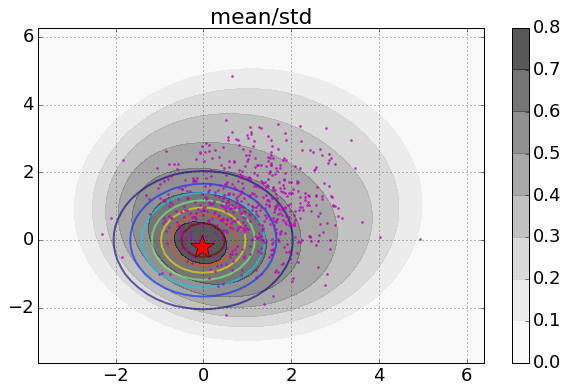

In [10]:
generic_contourf(p, dat, k, func_fssd_power_criterion)
plt.title('mean/std')
plt.colorbar()
plt.grid()

V: [ 1.41866495  1.4203354 ]


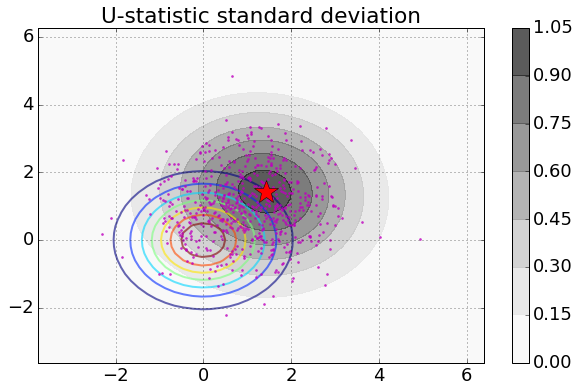

In [11]:
generic_contourf(p, dat, k, func_fssd_ustat_std)
plt.title('U-statistic standard deviation')
plt.colorbar()
plt.grid()

## Plots in 1D

In [10]:
# true p
seed = 21
d = 1
mean = np.zeros(d)
variance = 1
p = density.IsotropicNormal(mean, variance)

# sample
n = 600

# only one dimension of the mean is shifted
#draw_mean = mean + np.hstack((1, np.zeros(d-1)))
# draw_mean = mean + 1
# draw_variance = variance + 0
# X = util.randn(n, d, seed=seed+3)*np.sqrt(draw_variance) + draw_mean
# dat = data.Data(X)

# ds = data.DSIsotropicNormal(mean=mean, variance=variance)
# dat = ds.sample(n, seed=seed+3)
# X = dat.data()

ds = data.DSLaplace(d=1, loc=0, scale=1.0/np.sqrt(2))
dat = ds.sample(n, seed=seed+3)
X = dat.data()


In [11]:
# Kernel
sig2 = util.meddistance(X, subsample=1000)**2
k = kernel.KGauss(sig2)

# Test
J = 1
alpha = 0.01

# random test locations
V = util.fit_gaussian_draw(X, J, seed=seed+1)
null_sim = gof.FSSDH0SimCovObs(n_simulate=2000, seed=10)
fssd = gof.FSSD(isonorm, k, V, null_sim=null_sim, alpha=alpha)
fssd.perform_test(dat)

{'alpha': 0.01,
 'h0_rejected': False,
 'n_simulate': 2000,
 'pvalue': 0.76849999999999996,
 'test_stat': -1.1577098702175814,
 'time_secs': 0.0034210681915283203}

### Plot

In [12]:
def generic_1d_locs_plot(p, dat, k, func, func_label=None, cond_locs=None, noise_level=None):
    """
    func: (p, dat, k, V) |-> value. A function computing the values to plot.
    cond_locs: J'xd matrix of test locations to condition on
    func_label: plot label for the function 
    """
    
    # should be an n x 1 matrix. 1d data.
    X = dat.data()
    max0 = np.max(X, 0)
    min0 = np.min(X, 0)
    
    sd0  = (max0-min0)*0.6
    # form a test location grid to try 
    nd0 = 170
    loc0_cands = np.linspace(min0-sd0/2, max0+sd0/2, nd0)
    # #candidates x 1
    all_locs = np.reshape(loc0_cands, (-1, 1) )
    
    # evaluate the function on each candidate on the grid. Size = (#candidates, )
    n_cand = len(loc0_cands)
    stat_grid = np.zeros(n_cand)
    
    for i in xrange(n_cand):
        vi = np.reshape(all_locs[i], (-1, 1))
        V = vi if cond_locs is None else np.vstack((vi, cond_locs))
        stat_grid[i] = func(p, dat, k, V)
    den_grid = np.exp(p.log_den(all_locs))
    
    plt.figure(figsize=(8, 4))
    # Plot the unnormalized density
    max_func = np.max(stat_grid)
    max_den = np.max(den_grid)
    #abs_max = max(max_func, max_den)
    abs_max = max_func
    
    rescaled_den = den_grid/max_den*abs_max*0.8
    #rescaled_stat = stat_grid/max_func*abs_max
    plt.plot(all_locs, rescaled_den, 'b-', label='$\propto p(\mathbf{x})$')
    plt.plot(all_locs, stat_grid, 'r-', label=func_label)
    # plot the data
    n = X.shape[0]
    if noise_level is None:
        noise_level = max(rescaled_den)*0.01
    with util.NumpySeedContext(seed=20):
        noise = np.random.randn(n)*noise_level
        plt.plot(X[:, 0], noise, 'm.', 
                 markeredgecolor='m', markersize=4, alpha=0.7, label='data')
    
    # plot the conditioning test locations
    if cond_locs is not None:
        for i in range(len(cond_locs)):
            loci = cond_locs[i]
            plt.stem(loci, [abs_max/2.0], 'g-', label='Cond. features')
    # plot the location achieving the peak of the function
    maxi = np.argmax(stat_grid)
    plt.plot([all_locs[maxi], all_locs[maxi]], [0, stat_grid[maxi]], 'k--')
    plt.plot(all_locs[maxi], 0., 'k^', markersize=20, label='arg max')
    
    plt.legend(bbox_to_anchor=(1.5, 1))
    #plt.xlabel('$X$')
    #plt.ylabelel('$Y$')
    

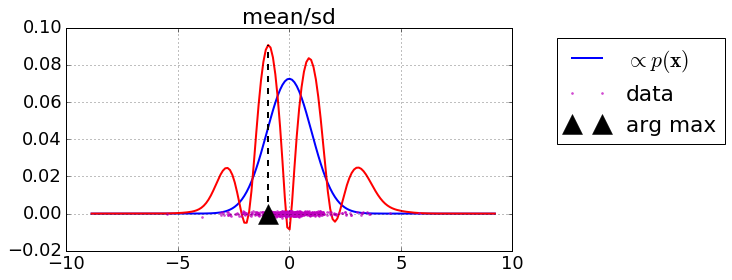

In [15]:
generic_1d_locs_plot(p, dat, k, func_fssd_power_criterion, func_label=None, 
                    cond_locs=None)
plt.title('mean/sd')
plt.grid()

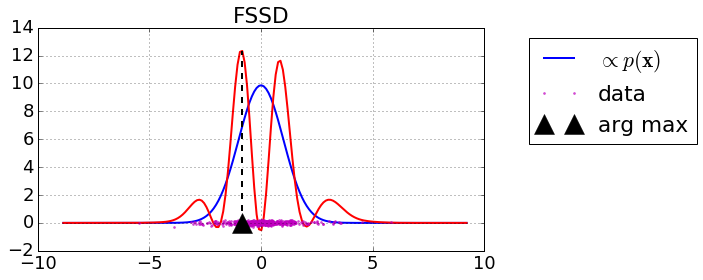

In [16]:
generic_1d_locs_plot(p, dat, k, func_fssd, func_label=None, cond_locs=None)
plt.title('FSSD')
plt.grid()

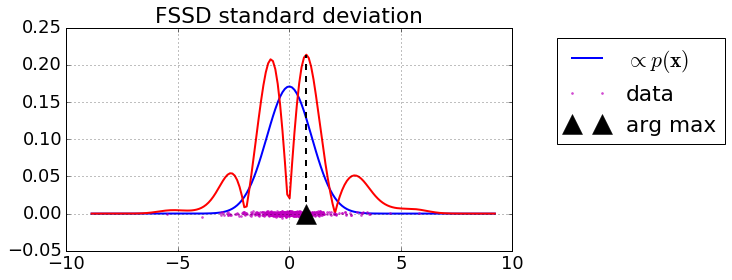

In [17]:
generic_1d_locs_plot(p, dat, k, func_fssd_ustat_std, func_label=None, cond_locs=None)
plt.title('FSSD standard deviation')
plt.grid()

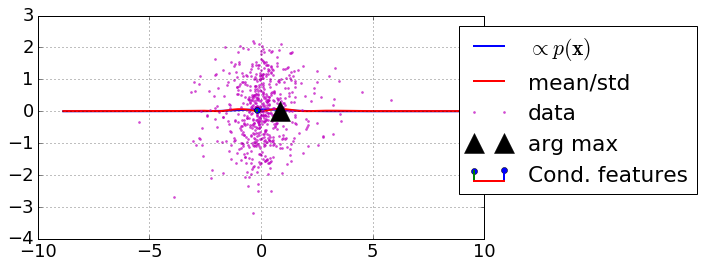

In [18]:
from ipywidgets import interact, interactive, fixed
from IPython.display import display
import ipywidgets as widgets
import math

def interactive_1d_locs_plot(f, func_label=None, cond_loc=None):
    cond_locs = np.array([[cond_loc]])
    generic_1d_locs_plot(p, dat, k, f, func_label=func_label, 
                    cond_locs=cond_locs, noise_level=1)
    plt.grid()

X = dat.data()
minx = np.min(X)
maxx = np.max(X)
sdx = np.std(X)
gap = 1
vs = interactive(interactive_1d_locs_plot,
    f=fixed(func_fssd_power_criterion), func_label=fixed('mean/std'), 
    cond_loc=(math.floor(minx-gap), math.ceil(maxx+gap), 0.2)
)
display(vs)